# Identification of HIV-1 Env Mutations that Enhance Usage of Macaque CD4 and CCR5

## Authors

Jeremy I. Roop, Noah A. Cassidy, Adam S. Dingens, Jesse D. Bloom, Julie Overbaugh. 

## Overview

This notebook describes analysis of sequencing reads obtained from a deep mutational scanning (DMS) experiment in which a library of mutational variants of the HIV-1 BF520 Env were selected by infection of 293T cells bearing either macaque or human CD4 and CCR5 receptors. These experiments were performed by Jeremy Roop in the [Bloom lab](https://research.fhcrc.org/bloom/en.html) during 2017 and 2018. 


### Import Python modules and define widely used paths

In [1]:
import os
import glob
import pandas
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.utils
from dms_tools2.ipython_utils import showPDF
import dms_tools2.sra
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import numpy as np
params = {'mathtext.default': 'regular' }    
plt.rcParams.update(params)

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)

# wt BF520 aa sequence
wt_seq_file = 'BF520_wt_seq_HXB2_numbering.csv'

# do we use existing results or generate everything new?
use_existing = 'yes' # no if you want to overwrite

Using dms_tools2 version 2.4.1


### Define function to calculate S<sub>mut</sub>/S<sub>wt</sub>

The function Calculate_mut_effect, defined below, will be used to calculate S<sub>mut</sub>/S<sub>wt</sub> from the inferred preferences as log<sub>2</sub>(mutant preference / wildtype preference). 


In [2]:
def Calculate_mut_effect(prefs_file, outfile):
    
    # create dictionary that will hold wt amino acid positions as keys and wt residue as values
    wt_dict = {}
    with open(wt_seq_file) as f:
        for line in f:
            wt_dict[line.split(",")[0]] = line.strip().split(",")[1]
            
            
    # now, read the residue preferences into a dictionary of dictionaries keyed by position then amino acid, then with frequency as the value    
    count_dict = {}
    aas = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

    with open(prefs_file) as f:
        for line in f:
            if "site" in line:
                continue
            
            site = line.split(",")[0]
            count_dict[site] = {}
            for pos, aa in enumerate(aas, start=1):
                count_dict[site][aa] = float(line.split(",")[pos])              
                
    # now, calculate the fold change over wt for each residue at each site          
    for site in count_dict:
    
        wt = wt_dict[site]
        wt_freq = count_dict[site][wt]
    
        for aa in count_dict[site]:
            count_dict[site][aa] = math.log((count_dict[site][aa] / wt_freq),2)
            
    # write the fold change values to the outfile
    
    f = open(outfile, 'w')
    f.writelines('site,wildtype,mutation,foldx_wt,mutdiffsel\n')## diffsel for the logoplot
    for site in count_dict:
    
        for aa in aas:  
     
            f.writelines(site)
            f.writelines(","+str(wt_dict[site])+",")
            f.writelines(aa+',')
            f.writelines(str(count_dict[site][aa])+',')
            f.writelines(str(count_dict[site][aa]))
            f.writelines('\n')
    f.close()  
    

### Download sequencing reads from the SRA

The deep sequencing reads obtained from this experiment were submitted to the [Sequence Read Archive](http://www.ncbi.nlm.nih.gov/sra) as submission SUB5004183. The BioProject ID is [PRJNA512904](https://www.ncbi.nlm.nih.gov/bioproject/?term=PRJNA512904).

The samples are the mutant DNA libraries (mutDNA), the wildtype DNA error control (wt-DNA), the wildtype virus controls (wt-virus) and the human and macaque selected mutant virus samples (hu and rhm, respectivley). There are two replicates of all samples except for the wildtype DNA and wildtuype virus. 

In [3]:
# define accession numbers for each sample
samples = pandas.DataFrame.from_records(
        [('hu-1', 'SRR8389955'),
         ('hu-2', 'SRR8389954'),
         ('rhm-1', 'SRR8389953'),
         ('rhm-2', 'SRR8389952'),
         ('mutDNA-1', 'SRR8389949'),
         ('mutDNA-2', 'SRR8389948'),
         ('wt-DNA', 'SRR5241717'),
         ('wt-virus', 'SRR8389950')],       
        columns=['name', 'run']
        )

fastqdir = './data/fastq_files/' # path where the files will be downloaded to

print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )

print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))


Here are the names of the downloaded files now found in ./data/fastq_files/


name,run,R1,R2
hu-1,SRR8389955,hu-1_R1.fastq.gz,hu-1_R2.fastq.gz
hu-2,SRR8389954,hu-2_R1.fastq.gz,hu-2_R2.fastq.gz
rhm-1,SRR8389953,rhm-1_R1.fastq.gz,rhm-1_R2.fastq.gz
rhm-2,SRR8389952,rhm-2_R1.fastq.gz,rhm-2_R2.fastq.gz
mutDNA-1,SRR8389949,mutDNA-1_R1.fastq.gz,mutDNA-1_R2.fastq.gz
mutDNA-2,SRR8389948,mutDNA-2_R1.fastq.gz,mutDNA-2_R2.fastq.gz
wt-DNA,SRR5241717,wt-DNA_R1.fastq.gz,wt-DNA_R2.fastq.gz
wt-virus,SRR8389950,wt-virus_R1.fastq.gz,wt-virus_R2.fastq.gz


### Run dms2_batch_bcsubamp to process the fastq files and count mutations present in each sample

We used [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html), as described for the BF520 mutant Env library in [Dingens et al, 2017](https://www.ncbi.nlm.nih.gov/pubmed/28579254).

In [4]:
refseq = './BF520c2-Env.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['88,417,40,39', 
                       '418,753,39,35',
                       '754,1092,36,39',
                       '1093,1447,35,29',
                       '1407,1758,35,32',
                       '1759,2097,30,36'])
   
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples[['name', 'R1']].to_html(index=False)))
samples[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 205 \
        --R2trim 212 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
hu-1,hu-1_R1.fastq.gz
hu-2,hu-2_R1.fastq.gz
rhm-1,rhm-1_R1.fastq.gz
rhm-2,rhm-2_R1.fastq.gz
mutDNA-1,mutDNA-1_R1.fastq.gz
mutDNA-2,mutDNA-2_R1.fastq.gz
wt-DNA,wt-DNA_R1.fastq.gz
wt-virus,wt-virus_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


### Examine summary plots produced by dms2_batch_bcsubamp

In [5]:
# define the path prefix for summary plots
countsplotprefix = os.path.join(countsdir, 'summary') 

The *_readstats plot show statistics on the reads for each sample. Reads that failed the Illumina quality filter were removed prior to processing here and are not shown. This plot shows that a small proportion of reads were considered low quality and discarded, but most reads were retained. 

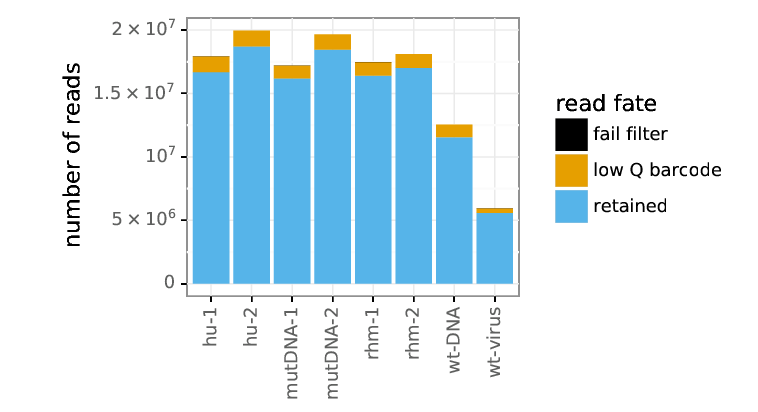

In [6]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The *_readsperbc.pdf plot shows the number of instances that each barcode was observed in each sample. Reads associated with barcodes observed only once will not be used to infer preferences. 

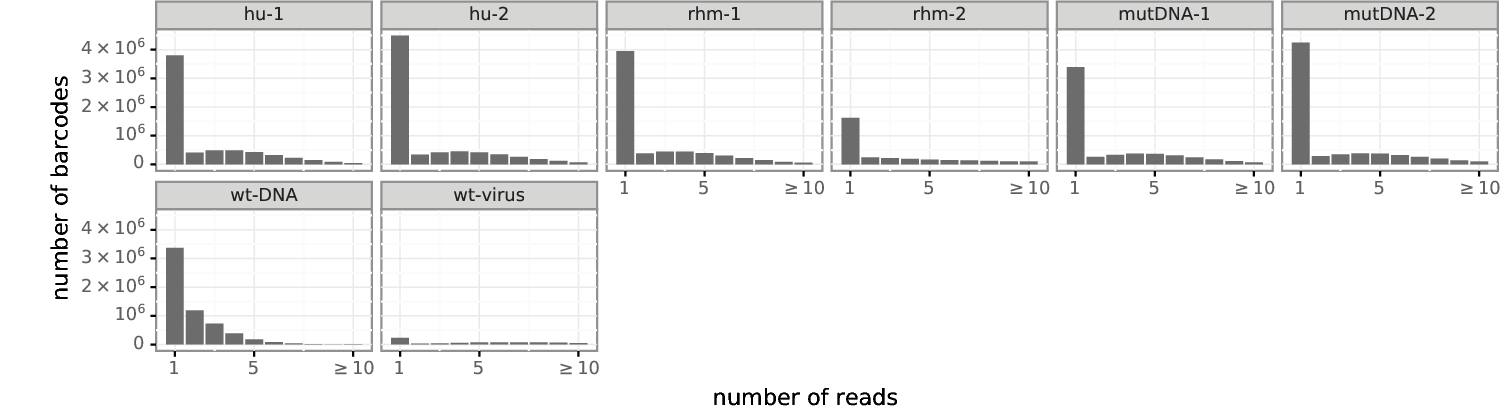

In [7]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The *_bcstats.pdf plot below shows statistics on the barcodes. The proportion of barcodes that only had one read associated with them are shown. These will be discarded, along with reads that could not be aligned to the BF520 Env. This plot, as well as the one above, reveal that many barcodes were only observed as singletons, thereby suggesting that additional sequencing depth could have increased the number of barcodes used in this analysis. That said, the number of barcodes that did align is still greater than in [previous succesful DMS experiments that used the BF520 Env library](https://github.com/jbloomlab/dms_tools2/blob/master/examples/Dingens2017/analysis_notebook.ipynb). 



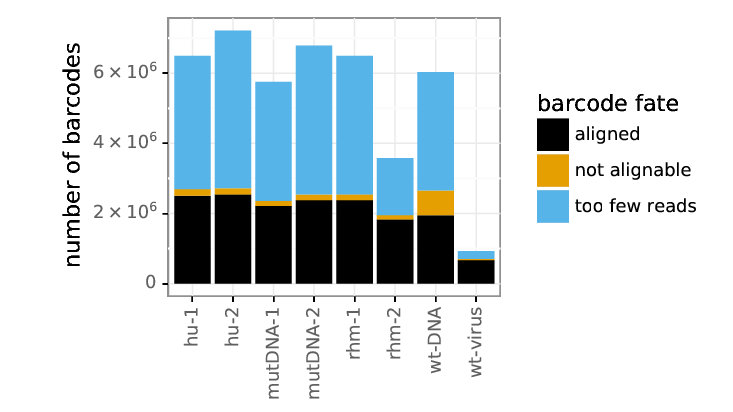

In [8]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The *_depth.pdf plot shows the number of called codons at each site in the gene. The fourth subamplicon has lesser depth than other subamplicons, indicating poor amplification of this subamplicon. The minimum depth of ~2 x 10^5 for this subamplicon is still comparable to previous DMS experiments.

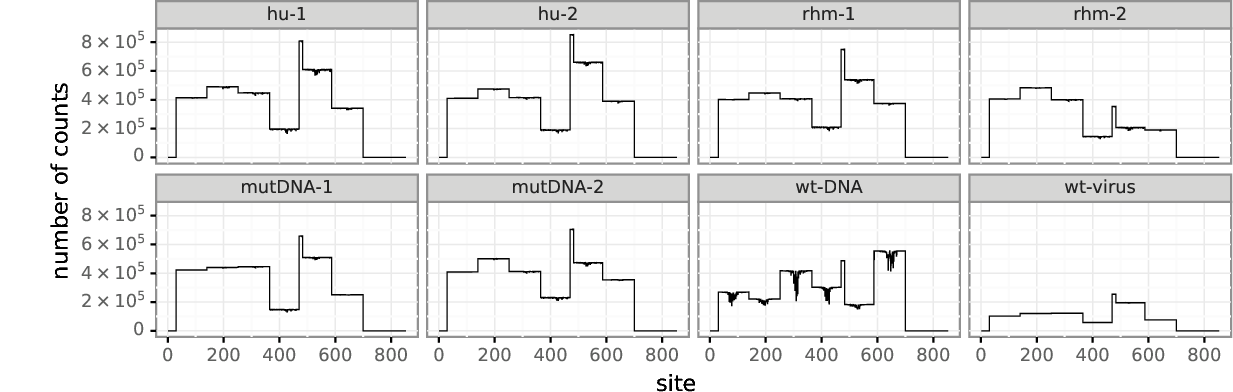

In [9]:
showPDF(countsplotprefix + '_depth.pdf')

The *_mutfreq.pdf plot shows the per-codon frequency of mutations at each site. For the macaque selected samples, we see a large peak towards the 3' end of the gene, which corresponds to the enrichment of mutations in the CHR region. Note that Env was not mutagenized past site 691, and thus there are no mutations past this point. 

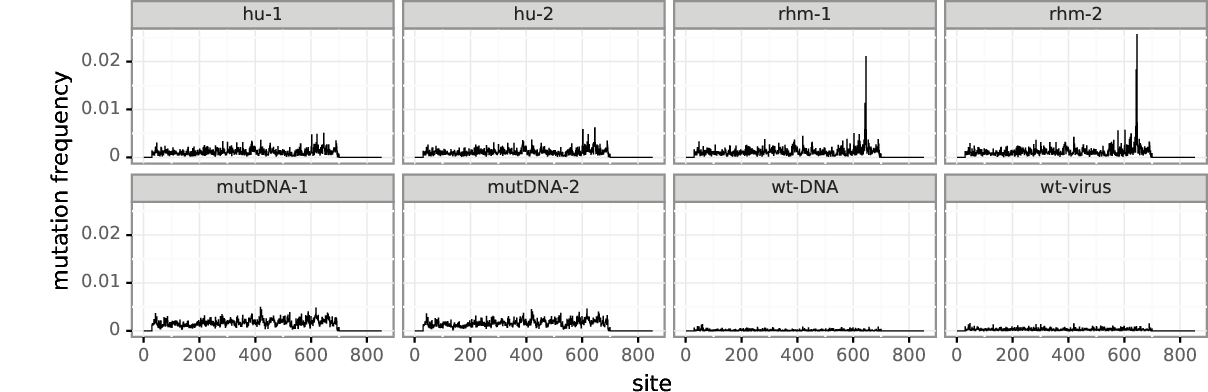

In [10]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The *_codonmuttypes.pdf plot shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. 
Human and macaque selected samples show a lower frequency of nonsynonymous and stop mutatoins relative to the mutant DNA plasmid libraries, evidence that many mutations present in the mutant plasmid library are deleterious during infection of both cell types. Nonsense mutations are similary purged during infection of cells bearing both human and macaque receptors. 


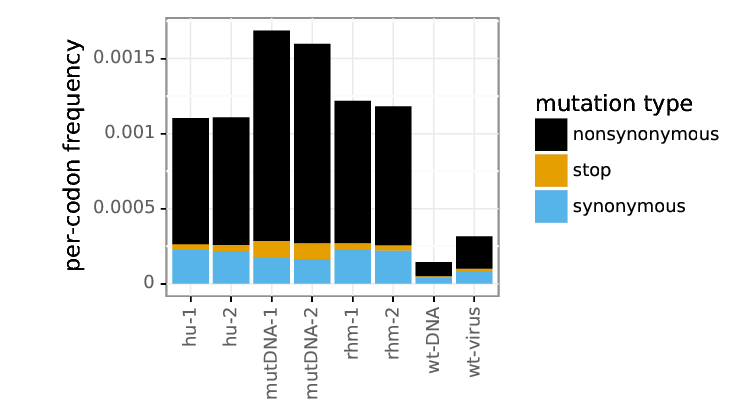

In [11]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

These data  allow us to determine the proportion of stop codons present in the mutant DNA library that remained after infection of cells bearing macaque and human receptors. This statistic indicates the extent to which the experiment selected against non-functinal Env mutations. Calculation of this statistic corrects for de-novo stop mutations that arrise during the experiment (estimated from the wt-virus sample), as well as sequencing errors. The 19% to 24% of stop codons remaining following selection is comparable to previous DMS experiments. 

In [12]:
# load the csv file containing frequencies of codon types
codon_type_df = pandas.read_csv(os.path.join(countsdir, 'summary_codonmuttypes.csv'), index_col='name')

# calculate stop codons remaining

print ("Proportion of stop codons remaining in selected libraries after correction for sequencing errors and de-novo mutation")
for name in ['hu-1','rhm-1']:
    print (name+": {:.2}".format((codon_type_df.loc[name,'stop'] - codon_type_df.loc['wt-virus','stop']) / (codon_type_df.loc['mutDNA-1','stop'] - codon_type_df.loc['wt-DNA','stop'])))
for name in ['hu-2','rhm-2']:
    print (name+": {:.2}".format((codon_type_df.loc[name,'stop'] - codon_type_df.loc['wt-virus','stop']) / (codon_type_df.loc['mutDNA-2','stop'] - codon_type_df.loc['wt-DNA','stop'])))
    

Proportion of stop codons remaining in selected libraries after correction for sequencing errors and de-novo mutation
hu-1: 0.21
rhm-1: 0.2
hu-2: 0.24
rhm-2: 0.19


The *_codonntchanges.pdf plot categorizes codon mutations by the number of nucleotides that are changed.



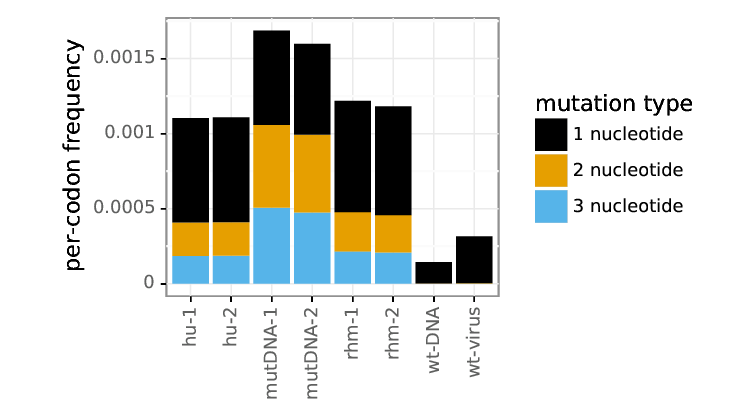

In [13]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The *_singlentchanges.pdf plot  shows the frequency of each type of nucleotide change among codon mutations with one nucleotide change. We observe an increased rate of transitions (G <-> A and C <-> T), as expected given that PCR errors preferentially introduce transitions, and as observed in previous DMS experiments. 



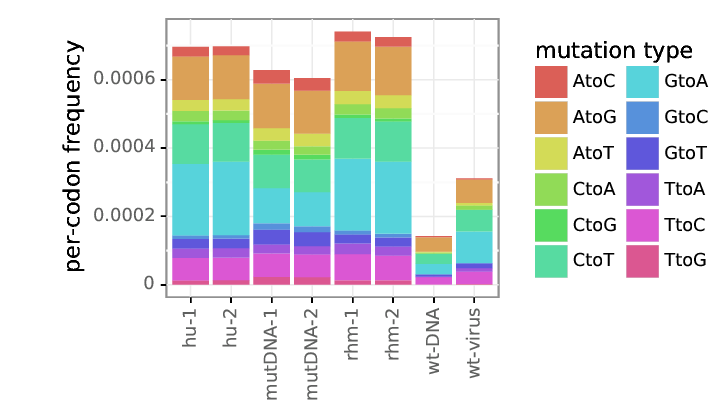

In [14]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

### Renumber codon counts to HXB2 numbering

We now renumber the positions of the counts obtained from dms2_batch_bcsubamp so as to correspond to the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html). The file ./data/BF520c2_to_HXB2.csv, obtained from [Dingens et al, 2017](https://www.ncbi.nlm.nih.gov/pubmed/28579254), contains the mapping from sequential numbering of the BF520 protein sequence to the HXB2 numbering scheme.


In [15]:
# file that maps BF520 sites onto HXB2 sites
renumberfile = './BF520c2_to_HXB2.csv'

# renumbered counts will go here
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

# counts files to renumber
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))

# renumber sites
dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', 
        outdir=renumberedcountsdir)

### Infer preferences for macaque selected samples 

Inference of preferences is accomplished using [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html). 

In [16]:
# preferences will be placed in this directory
macaque_prefsdir = os.path.join(resultsdir, 'rhesus_prefs')
if not os.path.isdir(macaque_prefsdir):
    os.mkdir(macaque_prefsdir)
    
# create batch file to run dms2_batch_prefs
prefsbatch = pandas.DataFrame( 
        columns=['group', 'name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('rhesus', 'replicate-1', 'mutDNA-1', 'rhm-1', 'wt-DNA', 'wt-virus'),
              ('rhesus', 'replicate-2', 'mutDNA-2', 'rhm-2', 'wt-DNA', 'wt-virus')
             ])

prefsbatchfile = os.path.join(macaque_prefsdir, 'batch_Rhm_prefs.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,pre,post,errpre,errpost
rhesus,replicate-1,mutDNA-1,rhm-1,wt-DNA,wt-virus
rhesus,replicate-2,mutDNA-2,rhm-2,wt-DNA,wt-virus


In [17]:
# run dms2_batch_prefs 
print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {renumberedcountsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {macaque_prefsdir} \
        --summaryprefix summary \
        --use_existing 'yes' \
        --method 'bayesian'
print("Completed running dms2_batch_prefs")

Running dms2_batch_prefs...
Completed running dms2_batch_prefs


We  now show the correlation between preferences from the two macaque selected samples. This correlation, while modest, is comparable to correlations between preferences from previous [DMS experiments using th BF520 mutant Env library](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5910023/). 

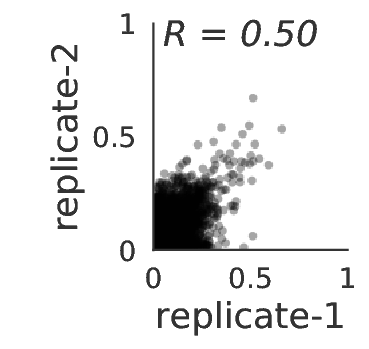

In [18]:
showPDF(os.path.join(macaque_prefsdir, 'summary_prefscorr.pdf'), width=300)

### Calculate S<sub>mut</sub>/S<sub>wt</sub> for macaque selected samples

The function Calculate_mut_effect, defined above, will be used to calculate S<sub>mut</sub>/S<sub>wt</sub> for each replicate of inferred preferences, and for the average of preferences from both replicates. S<sub>mut</sub>/S<sub>wt</sub> values will be written to files in the directory: './results/rhesus_mut_effects'. 



In [19]:
macaque_mut_effects_dir = os.path.join(resultsdir, 'rhesus_mut_effects')
if not os.path.isdir(macaque_mut_effects_dir):
    os.mkdir(macaque_mut_effects_dir)
Calculate_mut_effect(os.path.join(macaque_prefsdir, 'replicate-1_prefs.csv'), os.path.join(macaque_mut_effects_dir, 'replicate-1_mut_effects.csv'))
Calculate_mut_effect(os.path.join(macaque_prefsdir, 'replicate-2_prefs.csv'), os.path.join(macaque_mut_effects_dir, 'replicate-2_mut_effects.csv'))
Calculate_mut_effect(os.path.join(macaque_prefsdir, 'summary_avgprefs.csv'), os.path.join(macaque_mut_effects_dir, 'avgprefs_mut_effects.csv'))


We now display a scatterplot showing the correlation between S<sub>mut</sub>/S<sub>wt</sub> values for the two macaque selected samples. This correlation is similar to the correlation between preferences, as expected.

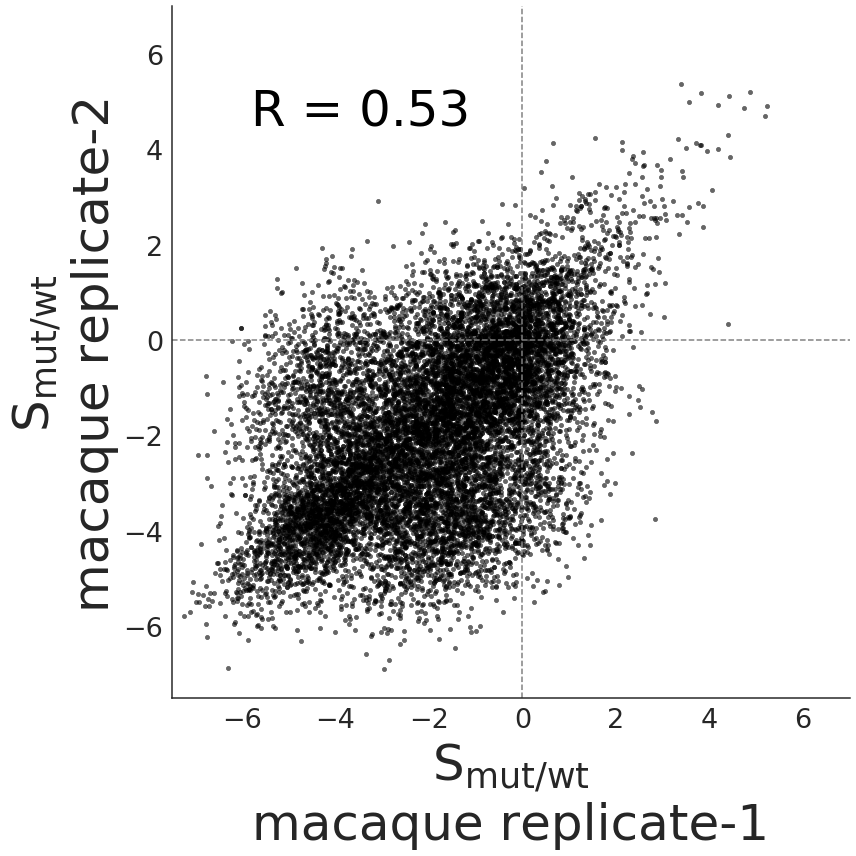

In [20]:
# set text format

params = {'mathtext.default': 'regular' }    
plt.rcParams.update(params)

# Read and format data

rep1_df = pandas.read_csv(os.path.join(macaque_mut_effects_dir, 'replicate-1_mut_effects.csv'))
rep2_df = pandas.read_csv(os.path.join(macaque_mut_effects_dir, 'replicate-2_mut_effects.csv'))
combined_df = pandas.concat([rep1_df, rep2_df['foldx_wt']], axis=1)
combined_df.columns = ['site,', 'wildtype', 'mutation', 'r1_foldx', 'r1_mutdiffsel', 'r2_foldx']

# make the plot

fig,ax = plt.subplots(figsize=(12, 12))
corr_plt = combined_df.plot.scatter(x='r1_foldx', y='r2_foldx', alpha=.6, c='black', ax=ax, rasterized=True)

# get the pearson corr coef
p_corr_df = combined_df.corr(method='pearson')
p_corr = p_corr_df.loc['r1_foldx'][2] 

# adjust plot 
corr_plt.set_ylim([-7.5,7])
corr_plt.set_xlim([-7.5,7])

corr_plt.set_ylabel('S$_{mut/wt}$\nmacaque replicate-2', fontsize=50)
corr_plt.set_xlabel('S$_{mut/wt}$\nmacaque replicate-1', fontsize=50)
corr_plt.axes.spines['top'].set_visible(False)
corr_plt.axes.spines['right'].set_visible(False)
corr_plt.axvline(x=0, color='grey', ls='--', lw=1.5)
corr_plt.axhline(y=0, color='grey', ls='--', lw=1.5)
for axis in ['top','bottom','left','right']:
        corr_plt.spines[axis].set_linewidth(1.5)
corr_plt.text(x=-5.8, y=4.5, s="R = {:.2f}".format(p_corr), color='black', size=50)
corr_plt.tick_params(axis='both', which='major', labelsize=27)
plt.tight_layout()
plt.savefig(os.path.join(macaque_mut_effects_dir, 'rhesus_mut_effects_corr.svg'))


### Infer preferences for human selected samples 

This is done as for the macaque selected samples above.

In [21]:
# prefs placed in this directory
hu_prefsdir = os.path.join(resultsdir, 'human_prefs')
if not os.path.isdir(hu_prefsdir):
    os.mkdir(hu_prefsdir)
    
# create batch file for dms2_batch_prefs
prefsbatch = pandas.DataFrame(
        columns=['group', 'name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('human', 'replicate-1', 'mutDNA-1', 'hu-1', 'wt-DNA', 'wt-virus'),
              ('human', 'replicate-2', 'mutDNA-2', 'hu-2', 'wt-DNA', 'wt-virus')
             ])

prefsbatchfile = os.path.join(hu_prefsdir, 'batch_Hu_prefs.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)


Here is the batch file that we write to CSV format to use as input:


group,name,pre,post,errpre,errpost
human,replicate-1,mutDNA-1,hu-1,wt-DNA,wt-virus
human,replicate-2,mutDNA-2,hu-2,wt-DNA,wt-virus


In [22]:
print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {renumberedcountsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {hu_prefsdir} \
        --summaryprefix summary \
        --use_existing 'yes' \
        --method 'bayesian'
print("Completed running dms2_batch_prefs")


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


Here is the the correlation between Hu replicate preferences. The correlation is much higher than between macaque selected samples. 

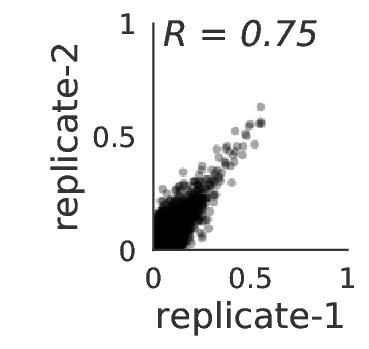

In [23]:
 showPDF(os.path.join(hu_prefsdir, 'summary_prefscorr.pdf'), width=300)

### Now calculate S<sub>mut</sub>/S<sub>wt</sub> for human selected samples

In [24]:
hu_mut_effects_dir = os.path.join(resultsdir, 'human_mut_effects')
if not os.path.isdir(hu_mut_effects_dir):
    os.mkdir(hu_mut_effects_dir)
Calculate_mut_effect(os.path.join(hu_prefsdir, 'replicate-1_prefs.csv'), os.path.join(hu_mut_effects_dir, 'replicate-1_mut_effects.csv'))
Calculate_mut_effect(os.path.join(hu_prefsdir, 'replicate-2_prefs.csv'), os.path.join(hu_mut_effects_dir, 'replicate-2_mut_effects.csv'))
Calculate_mut_effect(os.path.join(hu_prefsdir, 'summary_avgprefs.csv'), os.path.join(hu_mut_effects_dir, 'avgprefs_mut_effects.csv'))

We now display a scatterplot showing the correlation between S<sub>mut</sub>/S<sub>wt</sub> values for the two human receptor selected samples. This correlation is similar to the correlation between preferences, as expected.

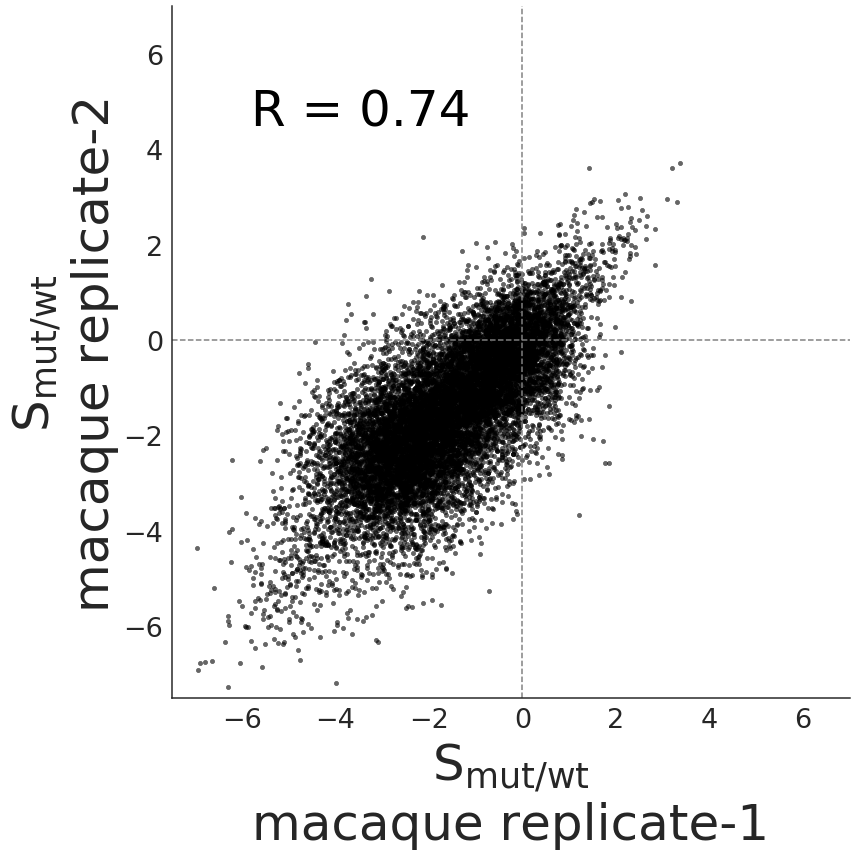

In [25]:
# set text format

params = {'mathtext.default': 'regular' }    
plt.rcParams.update(params)

# Read and format data

rep1_df = pandas.read_csv(os.path.join(hu_mut_effects_dir, 'replicate-1_mut_effects.csv'))
rep2_df = pandas.read_csv(os.path.join(hu_mut_effects_dir, 'replicate-2_mut_effects.csv'))
combined_df = pandas.concat([rep1_df, rep2_df['foldx_wt']], axis=1)
combined_df.columns = ['site,', 'wildtype', 'mutation', 'r1_foldx', 'r1_mutdiffsel', 'r2_foldx']

# make the plot

fig,ax = plt.subplots(figsize=(12, 12))
corr_plt = combined_df.plot.scatter(x='r1_foldx', y='r2_foldx', alpha=.6, c='black', ax=ax, rasterized=True)

# get the pearson corr coef
p_corr_df = combined_df.corr(method='pearson')
p_corr = p_corr_df.loc['r1_foldx'][2] 

# adjust plot 
corr_plt.set_ylim([-7.5,7])
corr_plt.set_xlim([-7.5,7])

corr_plt.set_ylabel('S$_{mut/wt}$\nmacaque replicate-2', fontsize=50)
corr_plt.set_xlabel('S$_{mut/wt}$\nmacaque replicate-1', fontsize=50)
corr_plt.axes.spines['top'].set_visible(False)
corr_plt.axes.spines['right'].set_visible(False)
corr_plt.axvline(x=0, color='grey', ls='--', lw=1.5)
corr_plt.axhline(y=0, color='grey', ls='--', lw=1.5)
for axis in ['top','bottom','left','right']:
        corr_plt.spines[axis].set_linewidth(1.5)
corr_plt.text(x=-5.8, y=4.5, s="R = {:.2f}".format(p_corr), color='black', size=50)
corr_plt.tick_params(axis='both', which='major', labelsize=27)
plt.tight_layout()
plt.savefig(os.path.join(hu_mut_effects_dir, 'human_mut_effects_corr.svg'))

### Plot the correlation between average S<sub>mut</sub>/S<sub>wt</sub> values from macaque and human selected samples

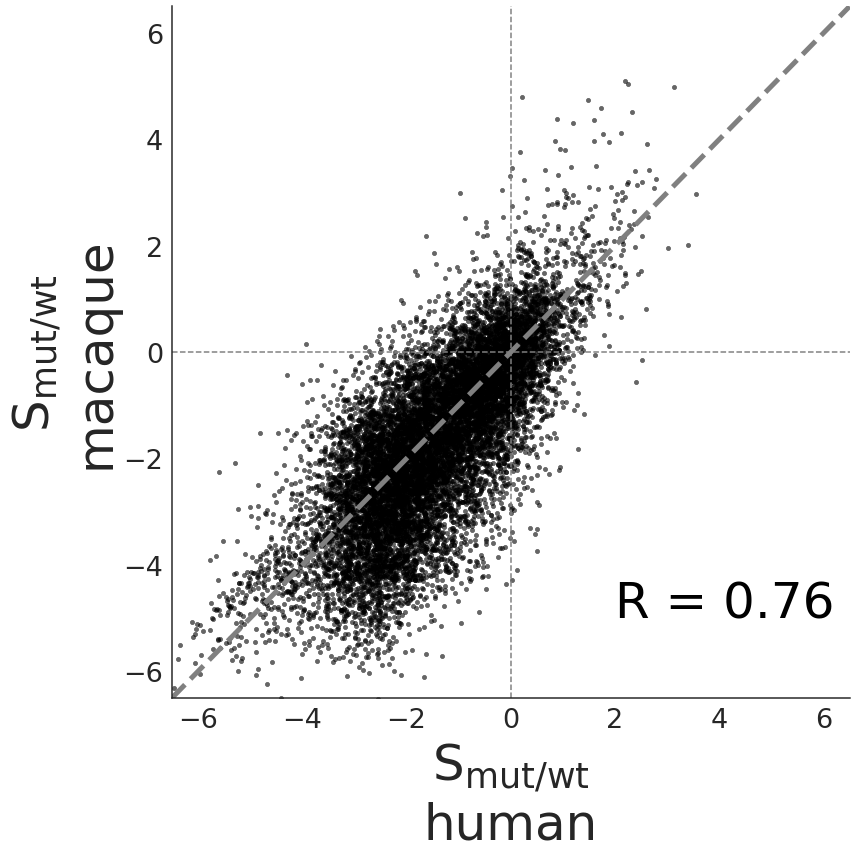

In [26]:
# define path for output

rhm_vs_hu_plot_dir = os.path.join(resultsdir, 'rhm_vs_hu_plots/')
if not os.path.isdir(rhm_vs_hu_plot_dir):
    os.mkdir(rhm_vs_hu_plot_dir)

# read and format data    
    
hu_avg_df = pandas.read_csv(os.path.join(hu_mut_effects_dir, 'avgprefs_mut_effects.csv'))
rhm_avg_df = pandas.read_csv(os.path.join(macaque_mut_effects_dir, 'avgprefs_mut_effects.csv'))
combined_df = pandas.concat([hu_avg_df, rhm_avg_df['foldx_wt']], axis=1)
combined_df.columns = ['site', 'wildtype', 'mutation', 'hu_foldx_wt', 'hu_avg_mutdiffsel', 'rhm_foldx_wt']

# make the plot

fig,ax = plt.subplots(figsize=(12, 12))
corr_plt = combined_df.plot.scatter(x='hu_foldx_wt', y='rhm_foldx_wt', alpha=.6, c='black', ax=ax, rasterized=True)

# get the pearson corr coef
p_corr_df = combined_df.corr(method='pearson')
p_corr = p_corr_df.loc['hu_foldx_wt'][2] 

# adjust plot 
corr_plt.set_ylim([-6.5,6.5])
corr_plt.set_xlim([-6.5,6.5])
corr_plt.set_ylabel('S$_{mut/wt}$\nmacaque', fontsize=50)
corr_plt.set_xlabel('S$_{mut/wt}$\nhuman', fontsize=50)
corr_plt.axes.spines['top'].set_visible(False)
corr_plt.axes.spines['right'].set_visible(False)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=5, ls='--', color='grey')
for axis in ['top','bottom','left','right']:
        corr_plt.spines[axis].set_linewidth(1.5)
corr_plt.text(x=2, y=-5, s="R = {:.2f}".format(p_corr), color='black', size=50)
corr_plt.axvline(x=0, color='grey', ls='--', lw=1.5)
corr_plt.axhline(y=0, color='grey', ls='--', lw=1.5)

corr_plt.tick_params(axis='both', which='major', labelsize=27)

plt.tight_layout() 
plt.savefig(os.path.join(rhm_vs_hu_plot_dir, 'avg_hu_vs_rhm_foldx_wt_corr.svg'))



### Plot all mutations with positive S<sub>mut</sub>/S<sub>wt</sub> values in the macaque selected samples.

Plotting uses [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).

['INFO:dms2_logoplot:Beginning execution of dms2_logoplot in directory /fh/fast/bloom_j/computational_notebooks/jroop/2016_env_DMS/191026_final_DMS_analysis_notebook', '', 'INFO:dms2_logoplot:Progress is being logged to ./results/rhesus_mut_effects/muteffects.log', 'INFO:dms2_logoplot:Version information:', '\tTime and date: Tue Oct 29 20:22:22 2019', '\tPlatform: Linux-3.13.0-165-generic-x86_64-with-debian-jessie-sid', '\tPython version: 3.6.7 | packaged by conda-forge | (default, Nov 21 2018, 02:32:25)  [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]', '\tdms_tools2 version: 2.4.1', '\tBio version: 1.70', '\tHTSeq version: 0.9.1', '\tpandas version: 0.23.4', '\tnumpy version: 1.13.3', '\tIPython version: 6.2.1', '\tjupyter version unknown', '\tmatplotlib version: 3.0.2', '\tplotnine version: 0.5.1', '\tnatsort version: 5.1.0', '\tpystan version: 2.16.0.0', '\tscipy version: 1.1.0', '\tseaborn version: 0.8.1', '\tphydmslib version: 2.3.1', '\tstatsmodels version: 0.8.0', '\trpy2 version: 2.9.

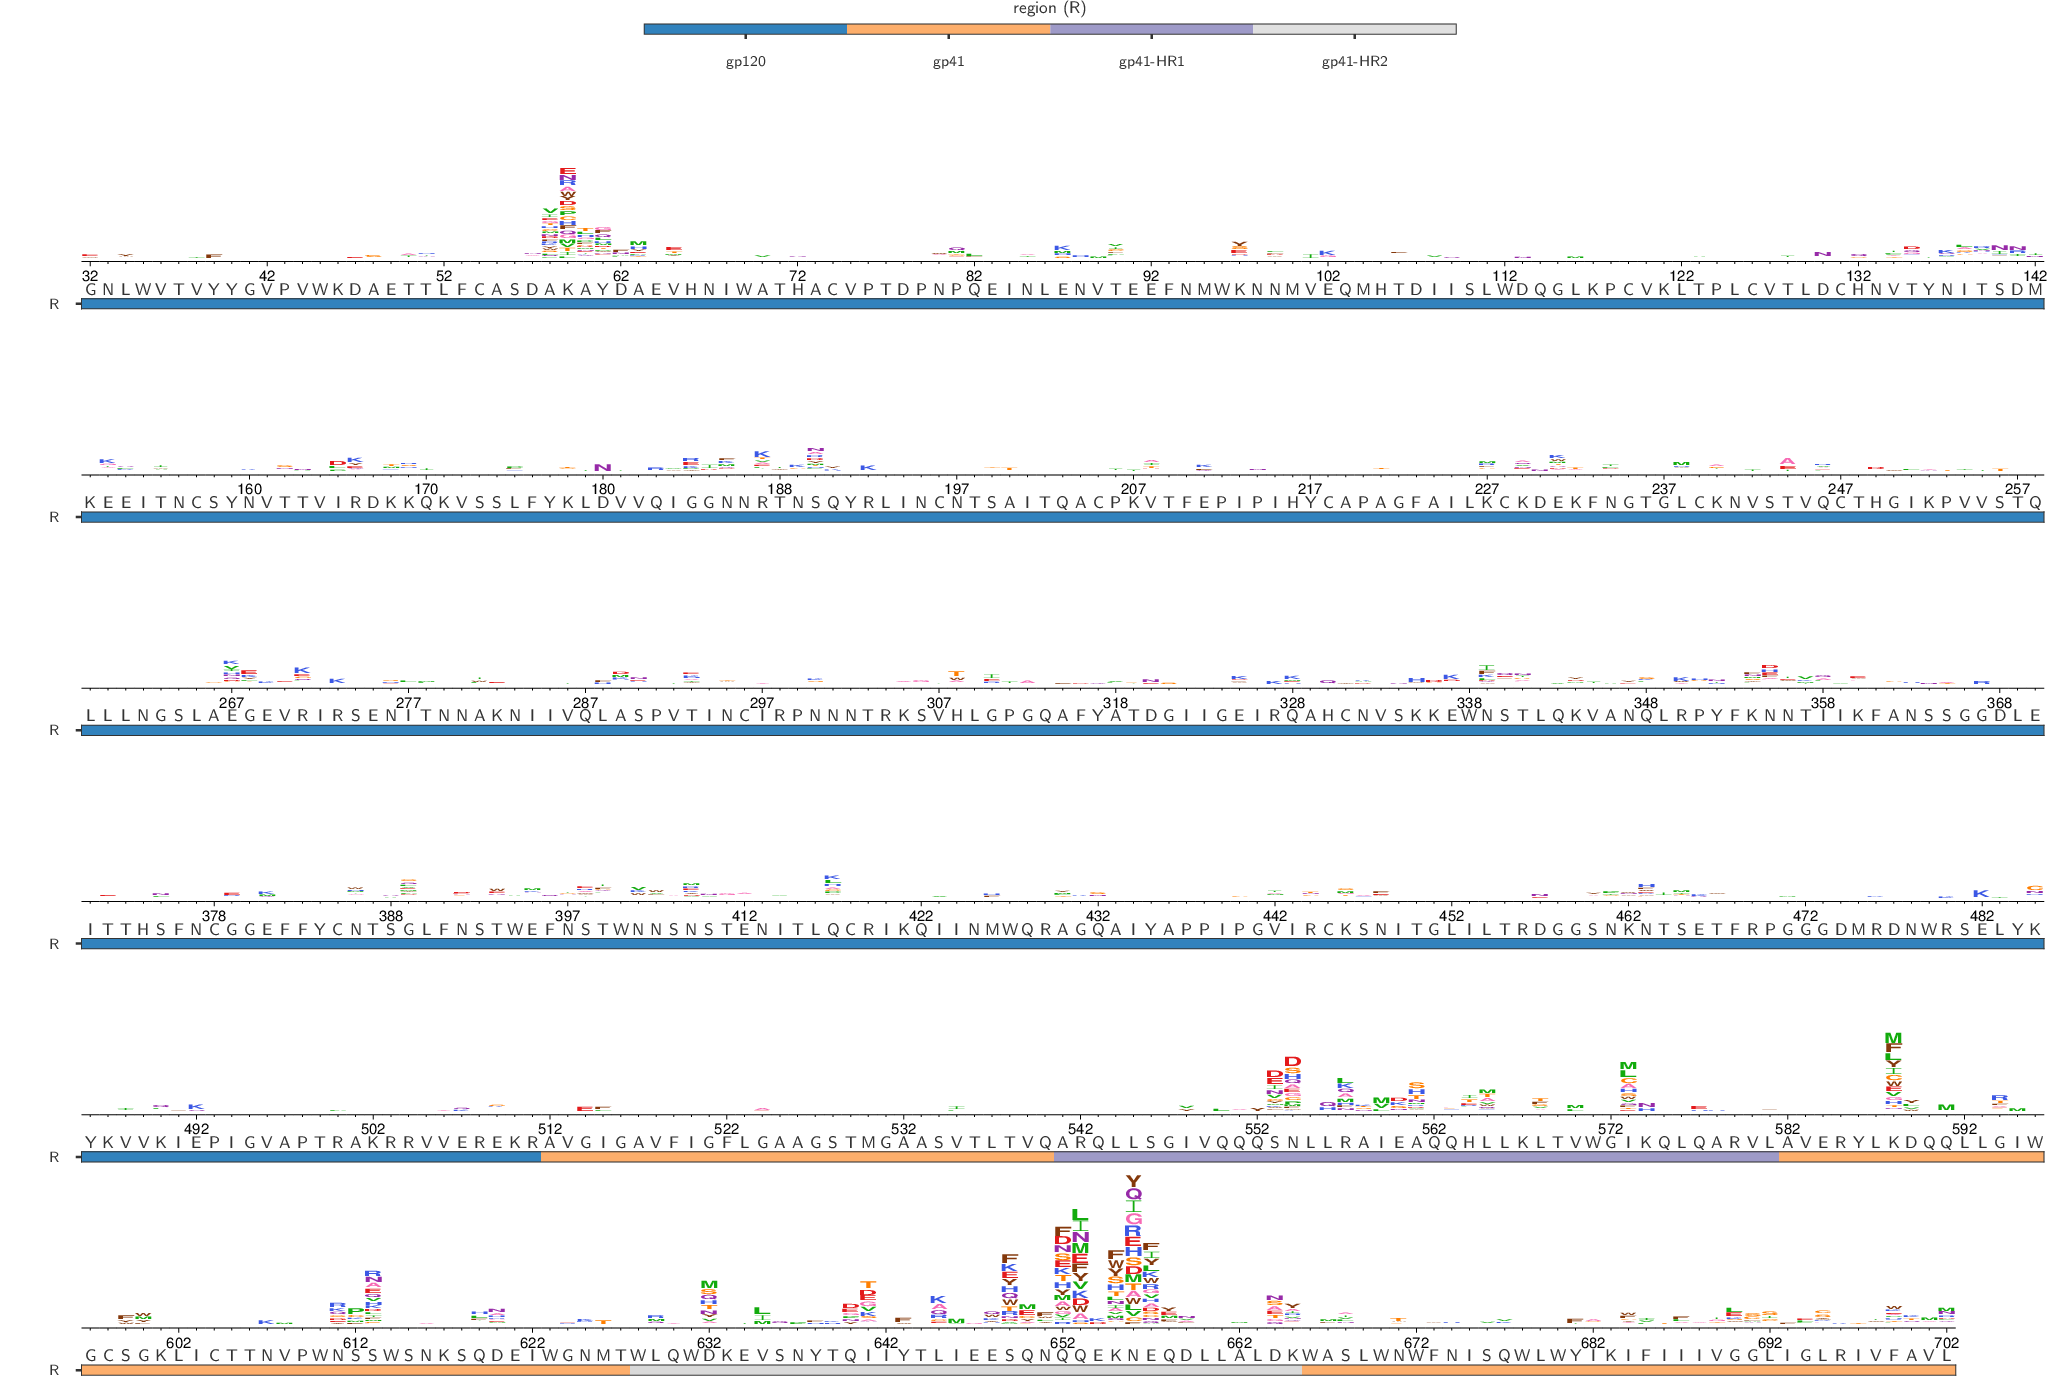

In [27]:
region_overlay = './env_features_overlay.csv' # this defines the coordinates of gp120, gp41, and NHR and CHR regions in Env. 
wtoverlayfile = './BF520_wt_seq.csv'
logoname = 'muteffects'
muteffects = os.path.join(macaque_mut_effects_dir, 'avgprefs_mut_effects.csv')

log = !dms2_logoplot \
        --diffsel {muteffects} \
        --name {logoname} \
        --outdir {macaque_mut_effects_dir} \
        --restrictdiffsel positive \
        --sepline no \
        --nperline 111 \
        --overlaycolormap tab20c \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {region_overlay} R region \
        --use_existing no \
        --diffselrange 0 59.5 \
        --underlay yes 
print (log)        
logoplot = os.path.join(macaque_mut_effects_dir, '{0}_diffsel.pdf'.format(logoname))
showPDF(logoplot)


### Plot all mutations with positive S<sub>mut</sub>/S<sub>wt</sub> values in the human selected samples.


['INFO:dms2_logoplot:Beginning execution of dms2_logoplot in directory /fh/fast/bloom_j/computational_notebooks/jroop/2016_env_DMS/191026_final_DMS_analysis_notebook', '', 'INFO:dms2_logoplot:Progress is being logged to ./results/human_mut_effects/muteffects.log', 'INFO:dms2_logoplot:Version information:', '\tTime and date: Sat Oct 26 17:44:13 2019', '\tPlatform: Linux-3.13.0-143-generic-x86_64-with-debian-jessie-sid', '\tPython version: 3.6.7 | packaged by conda-forge | (default, Nov 21 2018, 02:32:25)  [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]', '\tdms_tools2 version: 2.4.1', '\tBio version: 1.70', '\tHTSeq version: 0.9.1', '\tpandas version: 0.23.4', '\tnumpy version: 1.13.3', '\tIPython version: 6.2.1', '\tjupyter version unknown', '\tmatplotlib version: 3.0.2', '\tplotnine version: 0.5.1', '\tnatsort version: 5.1.0', '\tpystan version: 2.16.0.0', '\tscipy version: 1.1.0', '\tseaborn version: 0.8.1', '\tphydmslib version: 2.3.1', '\tstatsmodels version: 0.8.0', '\trpy2 version: 2.9.1

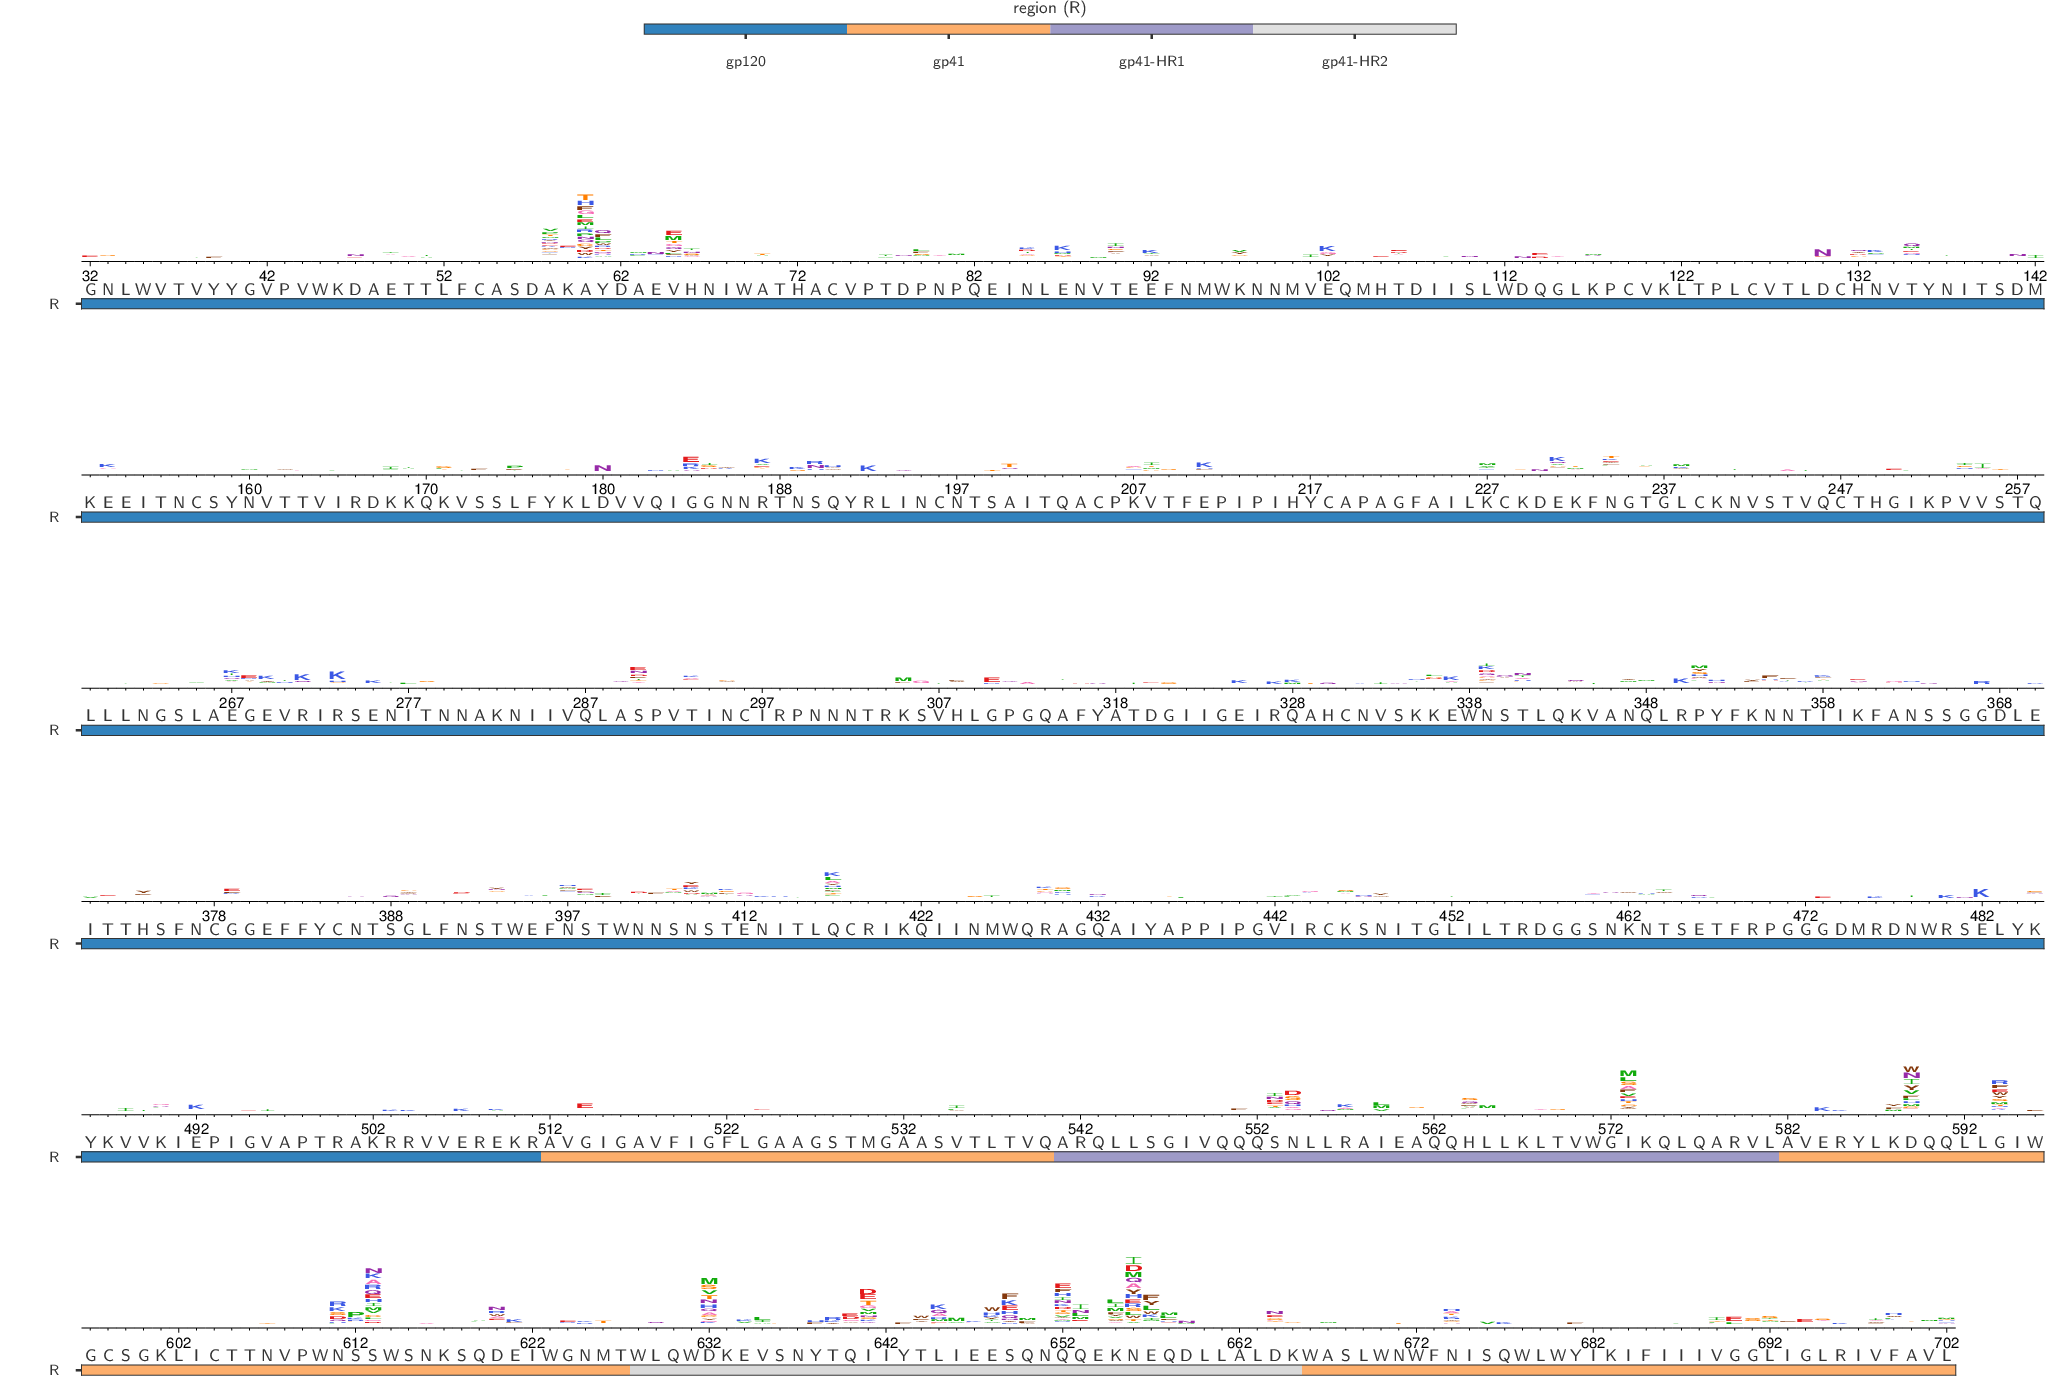

In [29]:
region_overlay = './env_features_overlay.csv'
wtoverlayfile = wt_seq_file
logoname = 'muteffects'
muteffects = os.path.join(hu_mut_effects_dir, 'avgprefs_mut_effects.csv')

log = !dms2_logoplot \
        --diffsel {muteffects} \
        --name {logoname} \
        --outdir {hu_mut_effects_dir} \
        --restrictdiffsel positive \
        --sepline no \
        --nperline 111 \
        --overlaycolormap tab20c \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {region_overlay} R region \
        --diffselrange 0 59.5 \
        --use_existing no \
        --underlay yes 
print (log)        
logoplot = os.path.join(hu_mut_effects_dir, '{0}_diffsel.pdf'.format(logoname))
showPDF(logoplot)
